In [1]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import re
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import *

from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
### READ DATA ###

df = pd.read_csv("Papers.csv")

print(df.shape)
df.head()

(403, 6)


,Id,Title,EventType,PdfName,Abstract,PaperText
0,5677,Double or Nothing: Multiplicative Incentive Me...,Poster,5677-double-or-nothing-multiplicative-incentiv...,Crowdsourcing has gained immense popularity in...,Double or Nothing: Multiplicative\nIncentive M...
1,5941,Learning with Symmetric Label Noise: The Impor...,Spotlight,5941-learning-with-symmetric-label-noise-the-i...,Convex potential minimisation is the de facto ...,Learning with Symmetric Label Noise: The\nImpo...
2,6019,Algorithmic Stability and Uniform Generalization,Poster,6019-algorithmic-stability-and-uniform-general...,One of the central questions in statistical le...,Algorithmic Stability and Uniform Generalizati...
3,6035,Adaptive Low-Complexity Sequential Inference f...,Poster,6035-adaptive-low-complexity-sequential-infere...,We develop a sequential low-complexity inferen...,Adaptive Low-Complexity Sequential Inference f...
4,5978,Covariance-Controlled Adaptive Langevin Thermo...,Poster,5978-covariance-controlled-adaptive-langevin-t...,Monte Carlo sampling for Bayesian posterior in...,Covariance-Controlled Adaptive Langevin\nTherm...


In [3]:
### DEFINE PREPROCESS FUNCTIONS ###

stop_words = set(stopwords.words('english'))

def create_sentence(text):
    output = []
    for s in re.split('\.\n|\.\r\n|\. ', text):
        output.extend(re.split('\n\n|\r\n\r\n', s))
    return output

def clean_sentence(sentence):
    sentence = strip_numeric(strip_non_alphanum(sentence)).lower().split()
    return [w for w in sentence if w not in stop_words]

In [4]:
### SELECT A PAPER AND APPLY PREPROCESS ###

corpus = create_sentence(df.PaperText[100])
cleaned_corpus = list(map(lambda s: clean_sentence(s), corpus))

In [5]:
### COMPUTE TFIDF WORD SCORES ON PAPER TEXT CORPUS ###

tfidf = TfidfVectorizer()
tfidf.fit(list(map(' '.join, cleaned_corpus)))

TfidfVectorizer()

In [6]:
%%time
### LOAD GLOVE WORD EMBEDDINGS WITH GENSIM ###

emb_dim = 300
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Wall time: 1min 26s


In [7]:
### DEFINE FUNCTION FOR SENTENCE EMBEDDINGS ###

def calculate_emb(clean_text, original_text):
    
    tfidf_feat = tfidf.get_feature_names()
    tfidf_emb = tfidf.transform(list(map(' '.join, clean_text)))
    final_sent_emb = []
    final_sent = []
    
    for row, sent in enumerate(tqdm(clean_text)):
        sent_vec = np.zeros(emb_dim)
        weight_sum = 0
        for word in sent:
            try:
                vec = model[word]
                tfidf_w_score = tfidf_emb[row, tfidf_feat.index(word)]
                sent_vec += (vec * tfidf_w_score)
                weight_sum += tfidf_w_score
            except:
                pass

        if sum(sent_vec)!=0:
            sent_vec /= weight_sum
            final_sent.append(original_text[row])
            final_sent_emb.append(sent_vec)
    
    final_sent_emb = np.asarray(final_sent_emb)
    final_sent = np.asarray(final_sent)
    
    return final_sent_emb, final_sent

In [8]:
### COMPUTE SENTENCE EMBEDDINGS ###

final_sent_emb, final_sent = calculate_emb(cleaned_corpus, corpus)

100%|██████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 2405.17it/s]


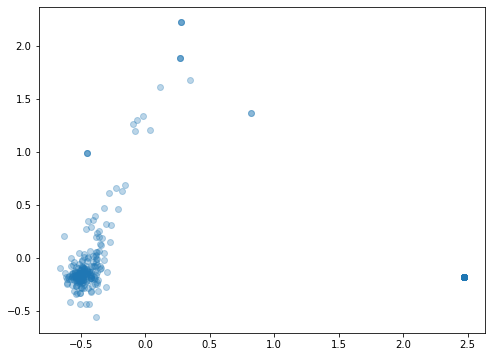

In [9]:
### 2D REPRESENTATION OF SENTENCES ###

pca = PCA(n_components=2)
X = pca.fit_transform(final_sent_emb)

plt.figure(figsize=(8,6))
plt.scatter(X.T[0], X.T[1], alpha=0.3)

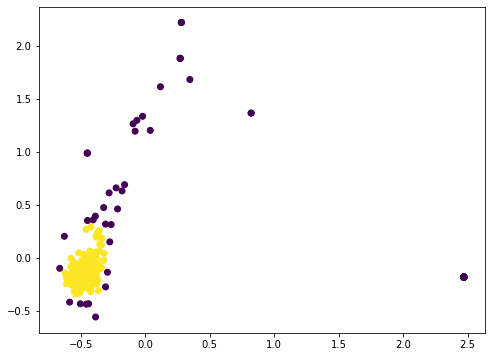

In [10]:
### COMPUTE ISOLATION FOREST FOR ANOMALY SENTENCES DETECTION ###

IF = IsolationForest(contamination=0.3)
IF.fit(X)

plt.figure(figsize=(8,6))
plt.scatter(X.T[0], X.T[1], c=IF.predict(X), cmap='viridis')

In [11]:
### GOOD SENTENCES ### 

final_sent[IF.predict(X) == 1].tolist()

['Shepard Convolutional Neural Networks',
 'Abstract\nDeep learning has recently been introduced to the field of low-level computer\nvision and image processing',
 'Promising results have been obtained in a number of tasks including super-resolution, inpainting, deconvolution, filtering, etc',
 'However, previously adopted neural network approaches such as convolutional\nneural networks and sparse auto-encoders are inherently with translation invariant\noperators',
 'We found this property prevents the deep learning approaches from\noutperforming the state-of-the-art if the task itself requires translation variant interpolation (TVI)',
 'In this paper, we draw on Shepard interpolation and design\nShepard Convolutional Neural Networks (ShCNN) which efficiently realizes endto-end trainable TVI operators in the network',
 'We show that by adding only a few\nfeature maps in the new Shepard layers, the network is able to achieve stronger\nresults than a much deeper architecture',
 'Superior

In [12]:
### BAD SENTENCES (ANOMALIES) ###

final_sent[IF.predict(X) == -1].tolist()

['Jimmy SJ',
 'Ren∗\nSenseTime Group Limited\nrensijie@sensetime.com',
 'Li Xu\nSenseTime Group Limited\nxuli@sensetime.com',
 'Qiong Yan\nSenseTime Group Limited\nyanqiong@sensetime.com',
 'Wenxiu Sun\nSenseTime Group Limited\nsunwenxiu@sensetime.com',
 'Project page: http://www.deeplearning.cc/shepardcnn',
 'Burger et al',
 'Xie et al',
 'Xu et al',
 '(K ∗ I)p / (K ∗ M)p\nIp',
 'Mp = 0\nMp = 1',
 'where I and J are the input and output images, respectively',
 'p indexes the image coordinates',
 'M is\nthe binary indicator',
 'where n is the index of layers',
 'j\nin Fjn−1 index the feature maps in layer n − 1',
 'We refer to\n4',
 'We can discern this from Eq',
 '1x1x128 filters are used in the fourth\nlayer',
 'The results of the comparisons are generated using the architecture in\n[8]',
 '(b) Bicubic / 22.10dB',
 '(c) KSVD / 23.57dB',
 '(d) NE+LLE / 23.38dB',
 '(e) ANR / 23.52dB',
 '(f) A+ / 24.42dB',
 '(g) SRCNN / 25.07dB',
 '(h) ShCNN / 25.63dB',
 'NE+NNLS',
 'NE+LLE',
 '24.86dB\